# Motivation
In another notebook (**TheNeedleDrop Scraping**), I defined a process to download data about each TheNeedleDrop review. Now, I want to create a couple of additional methods that create "enriched" versions of the files I've downloaded. 

Mostly, these "enriched" stats files will contain some important information about the video - description, publication date, album / artist information, etc. I'll try and parse the scores from the descriptions, and determine if videos are reviews or not. 

# Setup
The cells below will help to set up the rest of the notebook.

First, I'll change my working directory to the repo's root. 

In [1]:
# Changing the cwd to the repo root
%cd ..

C:\Data\Personal Study\Programming\neural-needle-drop


Next, I'll import some important modules.

In [168]:
# Import statements
import pandas as pd
import json
from pathlib import Path
from tqdm import tqdm
import re
import plotly.express as px
from time import sleep
from Levenshtein import ratio

# pytube-specific import statements
from pytube import YouTube
from pytube import Channel

# Import statements
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

We're also going to set up the Spotify client. We'll use this later on! 

In [169]:
# Setting up the API client
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

# Method Development
I'm going to try and develop a number of "helper methods" that help to enrich the different files. 

### Detecting Reviews
One method that I want to try and write: a "review" detector. Fantano releases a ton of different videos that aren't reviews - things like "top ____ of the year" sorta stuff.

The method below will try to use a video's title / description to determine if a video is a review or not.

In [3]:
# This method will attempt to determine whether a video is a review or not 
def detect_review(video_details_dict):
    
    # Determine if "album review" is a substring of the video title, and return a bool indicating that
    if video_details_dict["title"].lower().find("album review") == -1:
        return False
    else:
        return True

### Classifying Videos
Instead of just detecting if a video is an album review, we can write a more sophisticated "video classifier". This will search the titles to determine what type of video a particular video is. 

In [120]:
# This method will attempt to determine what type of video a particular video is 
def classify_video_type(video_details_dict):
    
    # Transform the video title to a lowercase string
    lowercase_video_title = video_details_dict["title"].lower()
    
    # Try and determine what type of video this one is by parsing the title 
    if lowercase_video_title.find("album review") != -1 and lowercase_video_title.count("-") > 0:
        return "album_review"
    elif lowercase_video_title.find("ep review") != -1:
        return "ep_review"
    elif lowercase_video_title.find("track review") != -1:
        return "track_review"
    elif lowercase_video_title.find("mixtape review") != -1:
        return "mixtape_review"
    elif lowercase_video_title.find("yunoreview") != -1 or lowercase_video_title.find("y u no review") != -1:
        return "yunoreview" 
    elif lowercase_video_title.find("weekly track roundup") != -1 or lowercase_video_title.find("best & worst tracks") != -1:
        return "weekly_track_roundup"
    elif lowercase_video_title.find("tnd podcast #") != -1:
        return "tnd_podcast"
    elif lowercase_video_title.find("vinyl update") != -1:
        return "vinyl_update"
    else:
        return "misc"

### Extracting Review Scores
The next method will attempt to use a regular expression to extract the review score from a video's description.

In [54]:
# This method will try to extract the review score from a video's description using a regex. 
# If successful, it'll return an int. If unsuccessful, it'll return None.
def extract_review_score(video_details_dict):
    
    # Try to parse the review score from the video's description
    try:
        video_description = video_details_dict["shortDescription"]
        search = re.findall(r'[^0-9][0-9]{1,2}/10', video_description, re.IGNORECASE)
        return int(search[-1].split("/")[0])
    
    # Return None if we ran into an error
    except Exception as e:
        return None

### Extracting Album Information
For the videos that're identified as album reviews, we can determine the artist and album title that're associated with them. 

In [116]:
# This method will try and extract the album title and artist name from a review's title
def extract_album_info(video_details_dict):
    try: 
        video_title = video_details_dict['title'].lower()
        single_dash = video_title.count("-") == 1
        if (single_dash):
            artist, album_title = [x.strip() for x in video_title.split("album review")[0].strip().split("-")]
        else:
            video_title = video_title.split("album review")[0]
            artist, album_title = [x.strip() for x in re.split(r'\s*-\s*', video_title, maxsplit=1)]
        return {"artist": artist, "album_title": album_title}
    except:
        return {"artist": None, "album_title": None}

### Searching Spotify for Album Info
I can use the Spotify API (via [spotipy](https://spotipy.readthedocs.io/en/2.22.0/#getting-started)) to search for information about each of the albums. 

In [176]:
def search_spotify_album_id(album_title, artist):
    
    # Search Spotify for a particular album
    try:
        search_str = f"{album_title} {artist}".lower()
        search_res = spotify.search(search_str, limit=1, type='album')
        sleep(1)

        # Extract some information from this Spotify search result
        album_id = search_res["albums"]["items"][0]['id']
        spotify_res_artist = search_res["albums"]["items"][0]["artists"][0]["name"]
        spotify_res_album_title = search_res["albums"]["items"][0]["name"]
        spotify_res_search_str = f"{spotify_res_album_title} {spotify_res_artist}".lower()

        # Determine how similar the result was to the search string 
        lev_sim = ratio(spotify_res_search_str.lower(), search_str)

        # If the result is above a particular similarity, we're going to return that information
        if (lev_sim >= 0.8):
            return album_id
        else:
            return None
        
    # If we run into an Exception, return None 
    except:
        return None

# Collecting Stats
Now that I've defined a number of the methods above, I want to determine some information about the different videos I'd downloaded. 

I'll start by creating a DataFrame of all of the videos I'd downloaded. 

In [121]:
# Create a DataFrame containing all of the data scraped for each of the videos
tnd_data_df_records = []
for child_dir in tqdm(list(Path("data/theneedledrop_scraping/").iterdir())):
    
    # Extract the video ID from the 
    cur_video_id = child_dir.name
    
    # Load in the details.json file
    try:
        with open(f"data/theneedledrop_scraping/{cur_video_id}/details.json", "r") as json_file:
            cur_details_dict = json.load(json_file)
    except:
        cur_details_dict = {}
        
    # Load in the transcription.json file
    try:
        with open(f"data/theneedledrop_scraping/{cur_video_id}/transcription.json", "r") as json_file:
            cur_transcription_dict = json.load(json_file)
    except:
        cur_transcription_dict = {}
        
    # Create a "record" for this video
    tnd_data_df_records.append({
        "video_id": cur_video_id,
        "details_dict": cur_details_dict,
        "transcription_dict": cur_transcription_dict
    })
    
# Now, we want to create a DataFrame from the tnd_data_df_records
tnd_data_df = pd.DataFrame.from_records(tnd_data_df_records)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3974/3974 [00:05<00:00, 682.47it/s]


With this collected, I'm going to start applying the different methods I've written to try and determine some info about the different videos. 

### Detecting Reviews
I've got two main questions for this section: 

1. What percentage of the videos are reviews? 
2. What are some of the titles that *aren't* reviews? (Knowing this could help with more "enrichment", since I'd be able to classify additional kinds of his videos.)

In [122]:
# Add a column to the tnd_data_df that indicates whether a video is a review or not 
tnd_data_df["is_review"] = tnd_data_df["details_dict"].apply(lambda x: detect_review(x))

# Show value counts for the "is_review" column
tnd_data_df["is_review"].value_counts()

True     2533
False    1441
Name: is_review, dtype: int64

What are some of the titles of videos that aren't reviews? 

In [123]:
# Print a couple of non-review video titles
for row in tnd_data_df.query("is_review==False")["details_dict"].apply(
    lambda x: x['title'] if 'title' in x else None).head(10):
    print(row)

The Worst Albums of 2020
A$AP Mob - The Cozy Tapes Vol. 1: Friends- MIXTAPE REVIEW
Young Thug & Carnage - Young Martha EP REVIEW
Ed Sheeran, Taylor Swift, Snoop Dogg, Doja Cat | Weekly Track Roundup: 2/13/22
Jazmine Sullivan - Heaux Tales EP REVIEW
YUNOREVIEW: APRIL 2016
GREAT ALBUMS: May 2017
YUNOREVIEW: October 2019 (88rising, Foals, SOPHIE, Kim Gordon)
MASSIVE INTERVIEW: CAKES DA KILLA
Kendrick Lamar and J. Cole "Black Friday" Freestyle / Remixes TRACK REVIEW


- mixtape review
- ep review
- track review

### Classifying Videos

In [124]:
tnd_data_df["video_type"] = tnd_data_df["details_dict"].apply(
    lambda x: classify_video_type(x))

tnd_data_df["video_type"].value_counts()

album_review            2526
misc                     672
weekly_track_roundup     290
ep_review                118
track_review             106
yunoreview                95
mixtape_review            85
vinyl_update              42
tnd_podcast               40
Name: video_type, dtype: int64

In [125]:
# Print a couple of non-review video titles
for row in tnd_data_df.query("video_type=='misc'")["details_dict"].apply(
    lambda x: x['title'] if 'title' in x else None).head(60):
    print(row)

The Worst Albums of 2020
GREAT ALBUMS: May 2017
MASSIVE INTERVIEW: CAKES DA KILLA
Real ____?
On Track with The Needle Drop – Danny Brown
GREAT ALBUMS: April 2017
R.I.P. Gil Scott Heron
Do drugs make music?
(april fools...except cal is dead!!!) Changing some scores to "10"
What makes a genre?
On Track With The Needle Drop - Denzel Curry
My Vinyl Collection: Part 3
Kanye West - Donda 2 v2.22.22 REVIEW
Listening To Computer-Generated Metal
I saw Sunn O)))
Depeche Mode, CHVRCHES, Tera Melos, Wire, Black Angels, TNGHT, Holograms, and more w/the Quickness
CAL CHUCHESTA IN A PARK
Opinions change!!!
SXSW '11 Vlog 3
Band shirts?????????
Getting friends into underground music.
EP ❤️: Rachel Chinouriri, EPROM & G Jones, SEBii, Blu & Fatlip
Various Artists - NOW That's What I Call Music, Vol. 69 COMPILATION REVIEW
3 Reviews: Cass McCombs / Childish Gambino / Africa Hitech
My Vinyl Collection: Part 1
NEW TRACK: Artificial Brain - "Absorbing Black Ignition"
Record Store Day Picks: 2013
My favorite b

### Extracting Review Scores
For those videos that *are* reviews: what's the score distribution? 

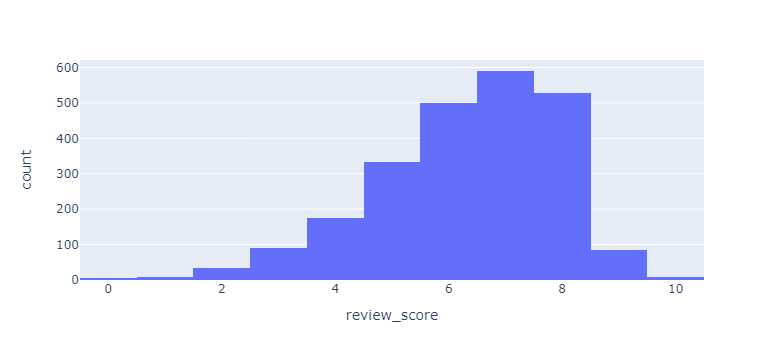

In [126]:
# Create a DataFrame consisting of exclusively album review videos
tnd_data_df_review_subset = tnd_data_df.query("video_type=='album_review'").copy()
tnd_data_df_review_subset["review_score"] = tnd_data_df_review_subset["details_dict"].apply(
    lambda x: extract_review_score(x))

# Create a visualization showing the distribution of scores 
score_value_count_df = tnd_data_df_review_subset["review_score"].value_counts().reset_index().rename(
    columns={"index": "score", "review_score": "ct"}).sort_values("score", ascending=True).copy()
fig = px.histogram(tnd_data_df_review_subset.query("review_score<=10"), x="review_score")
fig.show()

### Extracting Album Information

In [127]:
tnd_data_df_review_subset["album_info_dict"] = tnd_data_df_review_subset["details_dict"].apply(
    lambda x: extract_album_info(x))

### Searching Spotify for Album Info
Next, I want to try and get all of the Spotify album IDs for each of the albums within the NeedleDrop data. 

In [ ]:
spotify_album_id_df_records = []
for row in tqdm(list(tnd_data_df_review_subset.itertuples())):
    spotify_album_id_df_records.append({
        "video_id": row.video_id,
        "spotify_album_id": search_spotify_album_id(row.album_info_dict["album_title"], 
                                                    row.album_info_dict["artist"])
    })
    sleep(2.5)
spotify_album_id_df = pd.DataFrame.from_records(spotify_album_id_df_records)

  0%|▏                                                                                                                  | 3/2526 [00:11<2:34:18,  3.67s/it]